## Python 3.7 Notebook

### Basic Walkthrough of Recommender Algorithms
#### Code largely taken from https://towardsdatascience.com/how-to-build-a-simple-recommender-system-in-python-375093c3fb7d (with minor modifications)

### Load libraries

In [48]:
import pandas as pd 
import numpy as np
import scipy
import warnings
import random


### Set Up Basic Directory

In [2]:
dataDir=("C:/My Crap/Lurn/DSAIML/AIML/Recommender Test/data/")
dataDir_big=("C:/My Crap/Lurn/DSAIML/AIML/Recommender Test/data/ml-20m/")
dataDir_small=("C:/My Crap/Lurn/DSAIML/AIML/Recommender Test/data/ml-latest-small/")

### Load/Inspect Data

In [3]:
ratings = pd.read_csv(dataDir_small+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies = pd.read_csv(dataDir_small+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
links = pd.read_csv(dataDir_small+'links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [6]:
tags = pd.read_csv(dataDir_small+'tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


### Combine Data

In [7]:
moviesDataDF=ratings.merge(movies, on="movieId")
moviesDataDF.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [8]:
moviesDataDF.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [10]:
ratingsSummDF = pd.DataFrame(moviesDataDF.groupby('title')['rating'].mean())
ratingsSummDF.head()

,rating
title,
'71 (2014),4.0
'Hellboy': The Seeds of Creation (2004),4.0
'Round Midnight (1986),3.5
'Salem's Lot (2004),5.0
'Til There Was You (1997),4.0


In [11]:
ratingsSummDF['number_of_ratings'] = moviesDataDF.groupby('title')['rating'].count()
ratingsSummDF.head()

,rating,number_of_ratings
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


In [12]:
userRatingsSummDF = pd.DataFrame(moviesDataDF.groupby('userId')['rating'].mean())
userRatingsSummDF.head()

,rating
userId,
1,4.366379
2,3.948276
3,2.435897
4,3.555556
5,3.636364


In [13]:
userRatingsSummDF['number_of_ratings'] = moviesDataDF.groupby('userId')['rating'].count()
userRatingsSummDF.head()

,rating,number_of_ratings
userId,,
1,4.366379,232
2,3.948276,29
3,2.435897,39
4,3.555556,216
5,3.636364,44


In [14]:
ratingsSummDF['number_of_ratings'].plot.hist(bins=60)

In [15]:
ratingsSummDF['number_of_ratings'].describe()

count    9719.000000
mean       10.375141
std        22.406220
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: number_of_ratings, dtype: float64

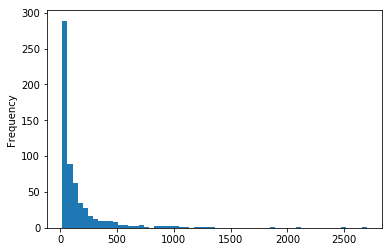

In [16]:
userRatingsSummDF['number_of_ratings'].plot.hist(bins=60)

In [17]:
userRatingsSummDF['number_of_ratings'].describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: number_of_ratings, dtype: float64

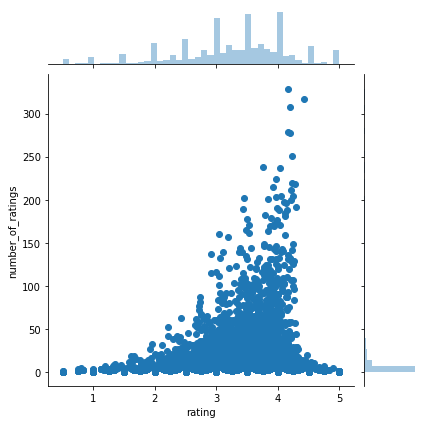

In [18]:
import seaborn as sns
sns.jointplot(x='rating', y='number_of_ratings', data=ratingsSummDF)

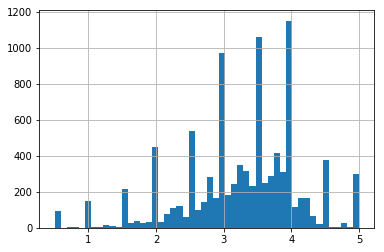

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
ratingsSummDF['rating'].hist(bins=50)

### Create Matrix

In [19]:
movie_matrix =moviesDataDF.pivot_table(index='userId', columns='title', values='rating')
movie_matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
ratingsSummDF.sort_values('number_of_ratings', ascending=False).head(10)

,rating,number_of_ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


In [21]:
ratingsSummDF[ratingsSummDF.number_of_ratings>10].sort_values('rating', ascending=False).head(10)

,rating,number_of_ratings
title,,
Secrets & Lies (1996),4.590909,11
Guess Who's Coming to Dinner (1967),4.545455,11
Paths of Glory (1957),4.541667,12
"Streetcar Named Desire, A (1951)",4.475000,20
"Celebration, The (Festen) (1998)",4.458333,12
Ran (1985),4.433333,15
"Shawshank Redemption, The (1994)",4.429022,317
His Girl Friday (1940),4.392857,14
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.333333,27


### Calculate Similarity/Correlations

In [22]:
AFO_user_rating = movie_matrix['Air Force One (1997)']
contact_user_rating = movie_matrix['Contact (1997)']

In [23]:
similar_to_air_force_one=movie_matrix.corrwith(AFO_user_rating)

C:\Users\kamal\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\kamal\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [24]:
similar_to_air_force_one.sort_values(ascending=False)

title
Let It Ride (1989)                                                                          1.0
Larry Crowne (2011)                                                                         1.0
Battlestar Galactica: Razor (2007)                                                          1.0
Be Cool (2005)                                                                              1.0
Andre (1994)                                                                                1.0
Child's Play 2 (1990)                                                                       1.0
Dr. T and the Women (2000)                                                                  1.0
Slither (2006)                                                                              1.0
Hairspray (2007)                                                                            1.0
Guarding Tess (1994)                                                                        1.0
Out to Sea (1997)                 

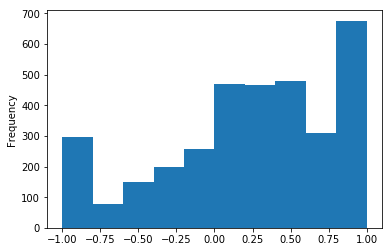

In [24]:
similar_to_air_force_one.plot.hist()

In [25]:
corr_AFO = pd.DataFrame(similar_to_air_force_one, columns=['correlation'])
corr_AFO.dropna(inplace=True)
corr_AFO.head()

,correlation
title,
"'burbs, The (1989)",0.168459
(500) Days of Summer (2009),0.086874
*batteries not included (1987),-0.866025
10 Cloverfield Lane (2016),0.192450
10 Items or Less (2006),-1.000000


In [26]:
corr_AFO.sort_values('correlation',ascending=False)

,correlation
title,
Dope (2015),1.0
Laws of Attraction (2004),1.0
Julie & Julia (2009),1.0
Song of the South (1946),1.0
Carnage (2011),1.0
My Left Foot (1989),1.0
"Horse Whisperer, The (1998)",1.0
Quicksilver (1986),1.0
Gone in 60 Seconds (1974),1.0


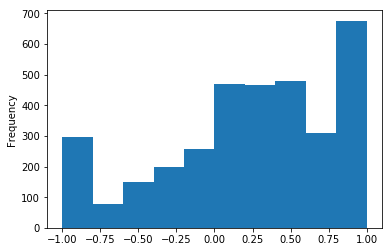

In [27]:
corr_AFO['correlation'].plot.hist()

In [28]:
similar_to_contact = movie_matrix.corrwith(contact_user_rating)

C:\Users\kamal\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\kamal\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [29]:
similar_to_contact.sort_values(ascending=False)

title
Norma Rae (1979)                                                                            1.0
Batman Beyond: Return of the Joker (2000)                                                   1.0
Stalingrad (1993)                                                                           1.0
Host, The (Gwoemul) (2006)                                                                  1.0
Doom Generation, The (1995)                                                                 1.0
Head of State (2003)                                                                        1.0
Guarding Tess (1994)                                                                        1.0
Precious (2009)                                                                             1.0
Vatel (2000)                                                                                1.0
Speed Racer (2008)                                                                          1.0
Dragnet (1987)                    

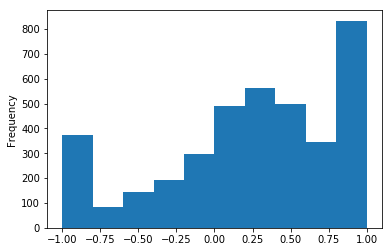

In [30]:
similar_to_contact.plot.hist()

In [31]:
corr_contact = pd.DataFrame(similar_to_contact, columns=['correlation'])
corr_contact.dropna(inplace=True)
corr_contact.head()

,correlation
title,
"'burbs, The (1989)",0.486761
(500) Days of Summer (2009),0.634064
*batteries not included (1987),0.868599
...And Justice for All (1979),1.000000
10 Things I Hate About You (1999),-0.102640


In [32]:
corr_contact.sort_values('correlation',ascending=False)

,correlation
title,
Grown Ups (2010),1.0
Armour of God (Long xiong hu di) (1987),1.0
Arthur (2011),1.0
"Thousand Acres, A (1997)",1.0
"Mosquito Coast, The (1986)",1.0
"Deep End of the Ocean, The (1999)",1.0
Derailed (2005),1.0
"Descendants, The (2011)",1.0
Armour of God II: Operation Condor (Operation Condor) (Fei ying gai wak) (1991),1.0


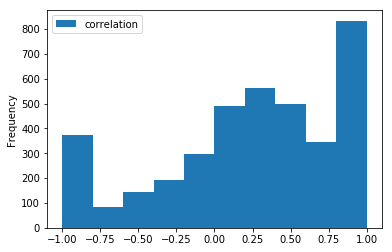

In [33]:
corr_contact.plot.hist()

In [34]:
corr_AFO = corr_AFO.join(ratingsSummDF['number_of_ratings'])
corr_AFO .head()

,correlation,number_of_ratings
title,,
"'burbs, The (1989)",0.168459,17
(500) Days of Summer (2009),0.086874,42
*batteries not included (1987),-0.866025,7
10 Cloverfield Lane (2016),0.192450,14
10 Items or Less (2006),-1.000000,3


In [35]:
corr_contact = corr_contact.join(ratingsSummDF['number_of_ratings'])
corr_contact.head()

,correlation,number_of_ratings
title,,
"'burbs, The (1989)",0.486761,17
(500) Days of Summer (2009),0.634064,42
*batteries not included (1987),0.868599,7
...And Justice for All (1979),1.000000,3
10 Things I Hate About You (1999),-0.102640,54


In [36]:
corr_AFO[corr_AFO['number_of_ratings'] > 50].sort_values(by='correlation', ascending=False).head(10)

,correlation,number_of_ratings
title,,
Air Force One (1997),1.000000,58
Tombstone (1993),0.823566,65
First Knight (1995),0.774474,54
Disclosure (1994),0.757937,52
City Slickers II: The Legend of Curly's Gold (1994),0.738997,55
Eraser (1996),0.729697,64
Demolition Man (1993),0.720565,81
"Three Musketeers, The (1993)",0.710015,61
Clear and Present Danger (1994),0.698836,110


In [37]:
corr_AFO[corr_AFO['number_of_ratings'] > 50].sort_values(by='correlation', ascending=True).head(10)

,correlation,number_of_ratings
title,,
12 Angry Men (1957),-0.610572,57
No Country for Old Men (2007),-0.550239,64
Dead Man Walking (1995),-0.489437,67
Edward Scissorhands (1990),-0.464145,80
This Is Spinal Tap (1984),-0.437588,66
Big (1988),-0.433998,91
Beetlejuice (1988),-0.432325,91
"Birdcage, The (1996)",-0.425043,86
Pirates of the Caribbean: Dead Man's Chest (2006),-0.406027,72


In [38]:
corr_contact[corr_contact['number_of_ratings'] > 50].sort_values(by='correlation', ascending=False).head(10)

,correlation,number_of_ratings
title,,
Contact (1997),1.000000,82
"Wolf of Wall Street, The (2013)",0.875113,54
Disclosure (1994),0.765532,52
First Knight (1995),0.731463,54
Coneheads (1993),0.712202,63
"Grand Budapest Hotel, The (2014)",0.699206,52
"Mask of Zorro, The (1998)",0.690878,60
Sleepless in Seattle (1993),0.689602,106
"Bourne Ultimatum, The (2007)",0.677770,81


In [39]:
corr_contact[corr_contact['number_of_ratings'] > 50].sort_values(by='correlation', ascending=True).head(10)

,correlation,number_of_ratings
title,,
The Hunger Games (2012),-0.776300,54
Zoolander (2001),-0.582433,54
Natural Born Killers (1994),-0.476273,92
Judge Dredd (1995),-0.475484,62
Dead Man Walking (1995),-0.409572,67
"Piano, The (1993)",-0.330043,61
Eyes Wide Shut (1999),-0.316314,53
Harry Potter and the Half-Blood Prince (2009),-0.308921,58
Kill Bill: Vol. 1 (2003),-0.283348,131


In [40]:
ratingsSummDF.loc['Contact (1997)']

rating                3.652439
number_of_ratings    82.000000
Name: Contact (1997), dtype: float64

In [41]:
ratingsSummDF.head()

,rating,number_of_ratings
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


### Cosine Similarity Measure

In [42]:
import nltk
from sklearn.metrics.pairwise import linear_kernel
from scipy.spatial.distance import cosine 

In [43]:
minMovieList=ratingsSummDF[ratingsSummDF.number_of_ratings>10].index

In [44]:
tempMatrix=movie_matrix.T
smallMovieMatrix=tempMatrix.loc[minMovieList]

In [45]:
smallMovieMatrix.shape

(2121, 610)

In [46]:
def ReturnCosineSim(ratingMatrix, target):
    tempMatrix = ratingMatrix.fillna(0)
    targetVec=tempMatrix.iloc[target]
    simDF=pd.DataFrame(columns=['itemNum', 'similarity'])
    simList=[]
    for item in range(len(tempMatrix)):
        if (target!=item):
            itemVec = tempMatrix.iloc[item]
            simList.append([item, -cosine(targetVec, itemVec)+1])
    return pd.DataFrame(simList,columns=['itemNum', 'similarity'])      
            
def ReturnMaxNSimilarItems(ratingMatrix, target,n=1):   
    simDF=ReturnCosineSim(ratingMatrix, target)
    topNDF=simDF.sort_values('similarity',ascending=False).head(n)
    indexNames=[ratingMatrix.index[i] for i in topNDF.itemNum]
    return pd.DataFrame({"itemName":indexNames, "similarity":topNDF["similarity"]})
        

In [52]:
tempTarget=random.sample(range(len(smallMovieMatrix)),1)[0]
print(smallMovieMatrix.index[tempTarget])
ReturnMaxNSimilarItems(smallMovieMatrix, target=tempTarget)

Proposal, The (2009)


,itemName,similarity
889,"Holiday, The (2006)",0.585521


### https://cambridgespark.com/practical-introduction-to-recommender-systems/

In [53]:
import io
import zipfile
import urllib
import surprise

In [54]:
tmpFile=urllib.request.urlopen('https://www.librec.net/datasets/filmtrust.zip')
tmpFile=zipfile.ZipFile(io.BytesIO(tmpFile.read()))
dataset=pd.read_table(io.BytesIO(tmpFile.read('ratings.txt')), sep=' ', names=['uid', 'iid', 'rating'])
tmpFile.close()

dataset.head()

C:\Users\kamal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,uid,iid,rating
0,1,1,2.0
1,1,2,4.0
2,1,3,3.5
3,1,4,3.0
4,1,5,4.0


In [55]:
lower_rating=dataset['rating'].min()
upper_rating=dataset['rating'].max()
print('Review range: {0} to {1}'.format(lower_rating, upper_rating))

Review range: 0.5 to 4.0


In [56]:
reader=surprise.Reader(rating_scale=(.5, 4.))
data=surprise.Dataset.load_from_df(dataset,reader)

In [58]:
alg=surprise.SVDpp()
output=alg.fit(data.build_full_trainset())

In [60]:
pred=alg.predict(uid='50', iid='52')
score=pred.est
print(score)

3.0028030537791928


In [62]:
iids=dataset['iid'].unique()
iids50=dataset.loc[dataset['uid']==50, 'iid']
iids_to_pred=np.setdiff1d(iids,iids50)

In [63]:
testset=[[50,iid,4.] for iid in iids_to_pred]
predictions=alg.test(testset)
predictions[0]

Prediction(uid=50, iid=14, r_ui=4.0, est=3.0904751914073105, details={'was_impossible': False})

In [71]:
pred_ratings=np.array([pred.est for pred in predictions])
i_max=pred_ratings.argmax()
iid=iids_to_pred[i_max]
print('Top item for user 50 has iid {0} with predicted rating {1}'.format(iid, pred_ratings[i_max]))

Top item for user 50 has iid 189 with predicted rating 4.0


In [72]:
iid

189

In [68]:
pred_ratings[i_max]

IndexError: too many indices for array

In [69]:
i_max

0

In [ ]:
pred_ratin